In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import sys
# sys.path.append("/home/pavithra/Pictures/learning/ML/kaggle/")
# sys.path
import kaggle_utils_py

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.impute import KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

### Conclution from EDA:
NoteBook: https://www.kaggle.com/ninjaac/complete-eda-song-popularity-prediction
- Need to handle missing values.
- Need to handle the distibution (skewness). [we can try transforming the data]
- Need to handle the outliers.
- Need to handle the Imbalance target.
- **More preference to models that are non-parametric and not so sentive to outliers.**

# Index 
- Intro to outliers
- Outlier Detection
- Method 1 - Choose models which are robust to outliers.
- Method 2 - Trimming
- Method 3 - Flooring & Capping
- Method 4 - Treat as missing values (Impute)
- Method 5 - Transformation
- Next

# Handling Outliers:

# Intro to Outliers in data.


- To learn about what is outlier ---> [outliers](https://en.wikipedia.org/wiki/Outlier) <br>
- How to find and for analysis on outliers check the EDA notebook ---> [EDA](https://www.kaggle.com/ninjaac/complete-eda-song-popularity-prediction) <br>
- kaggle_utils file available on ---> [kaggle_utils](https://www.kaggle.com/ninjaac/kaggle-utils-py) <br/>
To put in simple words, outliers are the error data in our dataset and our model not going to learn any useful information from that outliers. So, we need to handle it before modeling otherwise these outliers may cause misclassification and reduce the model performance.

## prepare the data(using data without any missing values).

In [8]:
%%time
data = pd.read_csv('../input/song-popularity-prediction/train.csv', index_col=0)
# as you seen in the EDA notebook this data has lots of missing values. i am gonna fill those valus using KNNimputer.
missing_features = kaggle_utils_py.find_features_with_missing_values(data)
knn_imptr = KNNImputer(n_neighbors=2)
data[missing_features] = knn_imptr.fit_transform(data[missing_features])
data.isna().sum()

CPU times: user 1min 4s, sys: 30.9 s, total: 1min 35s
Wall time: 1min 11s


song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
song_popularity     0
dtype: int64

# Outlier Detection
## IQR method
- This method can be applicable for Skewed data.
- lower limit = [Q1 - 1.5 * IQR] and upper limit = [Q3 +  1.5 * IQR] (Q1 --> 25 th quantail , Q3 --> 75th quantile , IQR --> inter quantile range (Q3 - Q1))
- The data point above upper limit and below lowe limit are outliers.
## Z-score method
- This method only applicable for normally distibuted data.
- lower limit = [mean - 3 * std] and upper limit = [mean + 3 * std] (std --> standard deviation)
- The data point above upper limit and below lowe limit are outliers.
## Percentail method
- This method  applicable for data which has other distibutions.
- We can set the upper limit and lower limit say upper limit = 95 percentail and lower limit = 5 percentail.
- Data which is not come under this range is called outliers.

The code to find outliers based on these methods are present in the EDA notebook.

In [9]:
# find the number of outliers each continues feature has.
# find the number of outliers on each features.
cotinuous_column_list = ['acousticness', 'danceability', 'energy',
                        'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence',
                        ] # we are not using the 'song_duration_ms' because it follows a normal distribution so need to use z-score method.
outliers = kaggle_utils_py.find_outliers_iqr_method(data[cotinuous_column_list])
display(outliers)
kaggle_utils_py.find_outlier_z_score_method(data["song_duration_ms"], col_name="song_duration_ms") # col name is must if you giving a single feature for test

,Features,Number of outliers
0,acousticness,0
1,danceability,0
2,energy,48
3,liveness,4776
4,loudness,1222
5,speechiness,3440
6,tempo,1191
7,audio_valence,0


,Feature,Number of outliers
0,song_duration_ms,391


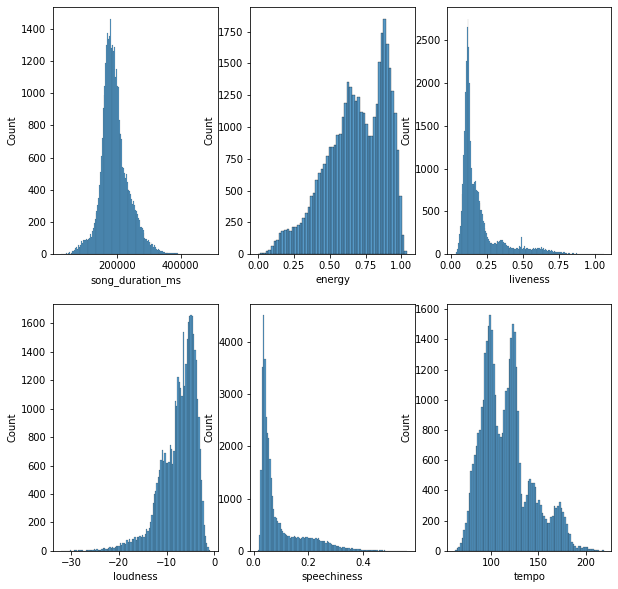

In [10]:
# find the distubution of the data. ( visualization would be so good)
column = ['song_duration_ms', 'energy',
                        'liveness', 'loudness', 'speechiness', 'tempo',]
plt.figure
fig, ax = plt.subplots(2,3, figsize=(10,10))
# we have 9 numerical values.
col, row = 3,2
col_count = 0
for r in range(row):
    for c in range(col):
        if col_count >= len(column):
            ax[r,c].text(0.5, 0.5, "no data")
        else:
            sns.histplot(data=data, x=column[col_count], ax=ax[r,c])
        col_count +=1
    


# Method 1 - Choose models which are robust to outliers.


- Need to select the model which are not sesitive(not affetced by) to outliers since we have lots of outliers.
- Because models which are sensitive to outliers consider outliers for classification so, single outlier value changes the whole classification. 
- Normally choose non-parametric models.


### List of Machine Learning algorithms which are sensitive to outliers: which is bad , because single data will change the whole classification (not ropust)
- 1- Linear Regression (Regression moedl --> Not going to use here)
- 2- Logistic Regression 
- 3- Support Vector Machine 
- 4- K- Nearest Neighbors 
- 5- Naive Bayes
- 3- XGBoost 
- 4- AdaBoost
- 6- CatBoot
- 6- K-Means Clustering (unsupervised moedl --> Not going to use here)
- 7- Hierarchical Clustering (unsupervised moedl --> Not going to use here)
- 8- Principal Component Analysis (unsupervised moedl --> Not going to use here)
### List of Machine Learning algorithms which are not sensitive to outliers. (robust)
- 1- Decision Tree 
- 2- Random Forest  <br>
[Tree based models are not affected by outliers]

### try one base model to see how outlier handling helps to classify effectively.

In [11]:
column = ['song_duration_ms', 'energy',
                        'liveness', 'loudness', 'speechiness', 'tempo',]
X , y = data.loc[:,column], data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)

In [12]:
# train the model with this X data.
# logestic regresion
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("Acuuracy of the model", accuracy_score(y_test, y_pred))

Acuuracy of the model 0.63775


In [13]:
# # logestic regresion
# random_forest = RandomForestClassifier(n_estimators=100)
# random_forest.fit(X_train, y_train)
# y_pred = random_forest.predict(X_test)
# print("Acuuracy of the model", accuracy_score(y_test, y_pred))

# Method 2 - Trimming

- Remove the rows which has outliers. 
- Not very gooe method, since we may loss information.
- We can use this when we have lots of data samples.

In [14]:
column = ['song_duration_ms', 'energy',
                        'liveness', 'loudness', 'speechiness', 'tempo',]
df, num_of_outliers = kaggle_utils_py.find_outliers_iqr_method(data[column], new_feature=True)
# The features will be added which says how may outliers in that particular row.
print("Shape of the original data --->",df.shape)
df.head()


Shape of the original data ---> (40000, 7)


,song_duration_ms,energy,liveness,loudness,speechiness,tempo,num_of_outliers
id,,,,,,,
0,212990.0,0.707073,0.525623,-5.619088,0.082570,158.386236,1
1,229361.5,0.835545,0.436428,-5.236965,0.127358,102.752988,1
2,193213.0,0.783524,0.170499,-4.951759,0.052282,178.685791,1
3,249893.0,0.552685,0.094805,-7.893694,0.035618,128.715630,0
4,165969.0,0.740982,0.094891,-2.684095,0.050746,121.928157,0


In [15]:
# remove the rows which has outliers.
d = df.copy()
d.drop(df[df['num_of_outliers'] > 0].index , axis=0, inplace=True)
X_trimmed = d.drop(['num_of_outliers'], axis=1)
# drop the same rows from target.
y_trimmed = data.iloc[:,-1].drop(df[df['num_of_outliers'] > 0].index , axis=0)
print("Shape of the X --->",X_trimmed.shape)
print("Shape of the y --->",y_trimmed.shape)


Shape of the X ---> (28787, 6)
Shape of the y ---> (28787,)


In [16]:
# train the model with this X data.
# logestic regresion
X_train, X_test, y_train, y_test = train_test_split(X_trimmed,y_trimmed,test_size=0.20)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("Acuuracy of the model", accuracy_score(y_test, y_pred))

Acuuracy of the model 0.6476207016325113


Accuracy is improved after outlier removel even thought we lost 1/4 of data in trimming.

# Method 3 - Flooring & Capping

- Find the upper and lower limits using any one of the outlier detection methods above.
- **Flooring** --- > For the values lower than lower limit , assign the lower limit value.
- **Capping** -----> For the values larger than upper limit , assign the upper limit value.
- Workes very well for the features with defined range. <br>
**Eg:**
- Let's say a feature has values ranging from 0-5 . So here surely the values larger than 5 is wrong and we can replace it with 5.

In [17]:
column = ['song_duration_ms', 'energy',
                        'liveness', 'loudness', 'speechiness', 'tempo',]
lower_limit_df, upper_limit_df = kaggle_utils_py.find_outliers_iqr_method(data[column], return_limits=True)

df_flooring_capping = data[column].copy()

# replace with upper_limit if the value greater than that.
def check_upper(row, upper_value):
    if row > upper_value:
        return upper_value[0]
    return row

# replce with lower_limit if the value lower than that.
def check_lower(row, lower_value):
    if row < lower_value:
        return lower_value[0]
    return row

# a = pd.Series([1,2,3,4,5])
# a = a.apply(check_upper, args=(4,))
# a
for col in column:
    lower_limit = np.array(lower_limit_df[lower_limit_df['Features'] == col]['lower limit'])
    upper_limit = np.array(upper_limit_df[upper_limit_df['Features'] == col]['upper limit'])
    df_flooring_capping[col] = df_flooring_capping[col].apply(check_upper, args=(upper_limit,))
    df_flooring_capping[col] = df_flooring_capping[col].apply(check_lower, args=(lower_limit,))
df_flooring_capping.head()

,song_duration_ms,energy,liveness,loudness,speechiness,tempo
id,,,,,,
0,212990.0,0.707073,0.366604,-5.619088,0.082570,158.386236
1,229361.5,0.835545,0.366604,-5.236965,0.127358,102.752988
2,193213.0,0.783524,0.170499,-4.951759,0.052282,175.800495
3,249893.0,0.552685,0.094805,-7.893694,0.035618,128.715630
4,165969.0,0.740982,0.094891,-2.684095,0.050746,121.928157


In [18]:
# check the outliers on log transforemd data.
column = ['song_duration_ms', 'energy',
                        'liveness', 'loudness', 'speechiness', 'tempo',]
print("before transformation")
display(kaggle_utils_py.find_outlier_z_score_method(data[column]))
print("after transformation")
kaggle_utils_py.find_outlier_z_score_method(df_flooring_capping[column]) # looks good

before transformation


,Features,Number of outliers
0,song_duration_ms,391
1,energy,35
2,liveness,1118
3,loudness,651
4,speechiness,682
5,tempo,157


after transformation


,Features,Number of outliers
0,song_duration_ms,0
1,energy,0
2,liveness,0
3,loudness,0
4,speechiness,0
5,tempo,0


In [19]:
# train the model with this X data.
# logestic regresion
column = ['song_duration_ms', 'energy',
                        'liveness', 'loudness', 'speechiness', 'tempo',]
X , y = df_flooring_capping.loc[:,column], data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("Acuuracy of the model", accuracy_score(y_test, y_pred))

Acuuracy of the model 0.628125


this method not helped here. So, try other techniques

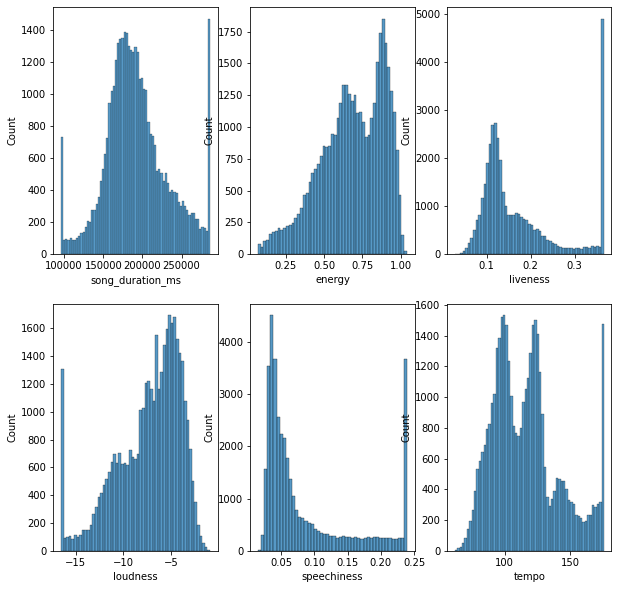

In [20]:
# find the distubution of the data. ( visualization would be so good)
column = ['song_duration_ms', 'energy',
                        'liveness', 'loudness', 'speechiness', 'tempo',]
plt.figure
fig, ax = plt.subplots(2,3, figsize=(10,10))
# we have 9 numerical values.
col, row = 3,2
col_count = 0
for r in range(row):
    for c in range(col):
        if col_count >= len(column):
            ax[r,c].text(0.5, 0.5, "no data")
        else:
            sns.histplot(data=df_flooring_capping, x=column[col_count], ax=ax[r,c])
        col_count +=1
    


# Method 4 - Treat as missing values (Impute)

- This is simple method treat the outliers as missing values and imputer them as you do for missing values.
- It can be your choise impute with mean, median, mode etc

# Method 5 - Transformation

- there is no lost of data.
- it won't always give the best results.
- boxcox transformation gives better results.

## Log transformation --> works better for right skewed data.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


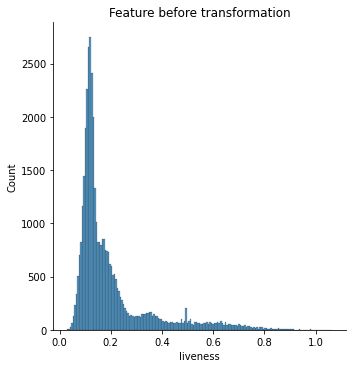

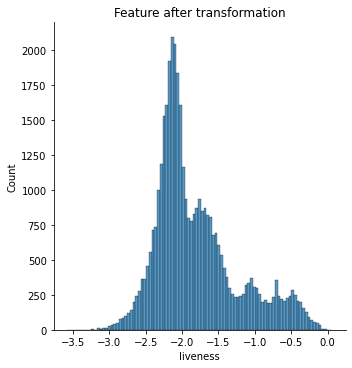

In [21]:
column_right_skewed = ['liveness', 'speechiness', ]
df = data[column_right_skewed]
for col in column_right_skewed:
    df[col] = np.log(df[col])

# plot the 2 features
sns.displot(data['liveness'])
plt.title("Feature before transformation")
sns.despine()
plt.show()

sns.displot(df['liveness'])
plt.title("Feature after transformation")
sns.despine()
plt.show()

- we can clearly see the diffrence between the 2 plot --> second one is looks like normal distribution now.
- check the outliers now.


In [22]:
# check the outliers on log transforemd data.
print("before transformation")
display(kaggle_utils_py.find_outlier_z_score_method(data['liveness']))
print("after transformation")
kaggle_utils_py.find_outlier_z_score_method(df['liveness']) # looks good

before transformation


,Feature,Number of outliers
0,Given feature,1118


after transformation


,Feature,Number of outliers
0,Given feature,27


## cube root transformation

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


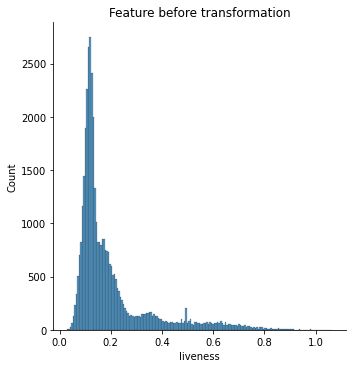

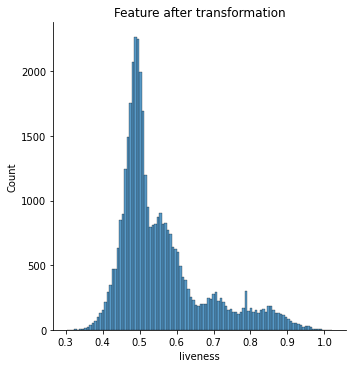

In [23]:
column_right_skewed = ['liveness', 'speechiness', ]
df = data[column_right_skewed]
for col in column_right_skewed:
    df[col] = (df[col] ** (1/3))

# plot the 2 features
sns.displot(data['liveness'])
plt.title("Feature before transformation")
sns.despine()
plt.show()

sns.displot(df['liveness'])
plt.title("Feature after transformation")
sns.despine()
plt.show()

In [24]:
# check the outliers on log transforemd data.
print("before transformation")
display(kaggle_utils_py.find_outlier_z_score_method(data['liveness']))
print("after transformation")
kaggle_utils_py.find_outlier_z_score_method(df['liveness']) # looks good

before transformation


,Feature,Number of outliers
0,Given feature,1118


after transformation


,Feature,Number of outliers
0,Given feature,389


## Box transformation

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


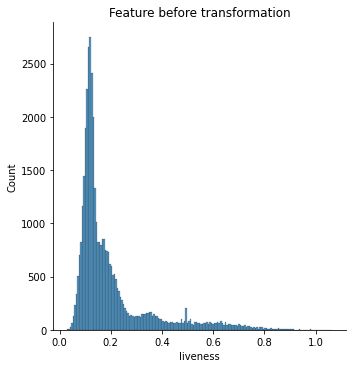

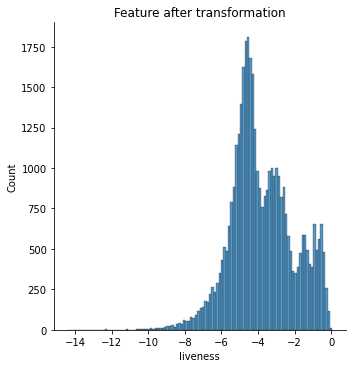

In [25]:
import scipy

column = ['liveness', 'speechiness', ]
df = data[column]
for col in column:
    df[col], filterd_lmbda = scipy.stats.boxcox(data[col], lmbda=None)

# plot the 2 features
sns.displot(data['liveness'])
plt.title("Feature before transformation")
sns.despine()
plt.show()

sns.displot(df['liveness'])
plt.title("Feature after transformation")
sns.despine()
plt.show()

In [26]:
# check the outliers on log transforemd data.
print("before transformation")
display(kaggle_utils_py.find_outlier_z_score_method(data['liveness']))
print("after transformation")
kaggle_utils_py.find_outlier_z_score_method(df['liveness']) # looks good

before transformation


,Feature,Number of outliers
0,Given feature,1118


after transformation


,Feature,Number of outliers
0,Given feature,133


# Next

Choose your method which gives better result for you......... happy learning :)